In [17]:
## Questa è l'analisi preliminare eseguita sui dati
## Elimina i dati registrati da misurazioni sbagliate o imprecise
## Aumenta il dataset con dati derivati a partire da dati presenti

In [18]:
## import librerie

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from shapely.geometry import LineString


In [19]:
## creazione df

df1= pd.read_csv("data/gps-22-12-2024.csv",
    usecols=[0, 1, 2, 3, 6 ,7], 
    names=["unixtime", "latitudine", "longitudine", "altitudine", "precisione_orizzontale", "precisione_verticale"] ## 
    )
df1['unixtime'] = df1['unixtime'].round(0)
## righe duplicate in unixtime
df1 = df1[df1.duplicated(subset="unixtime", keep='first') == False]

## dati utili da: 
df1 = df1[(df1['unixtime'] > 1734859000) & (df1['unixtime'] < 1734878750)].reset_index(drop=True) 
## a


## inserimento colonna per dati geospaziali

gdf1= gpd.GeoDataFrame(
    df1, 
    geometry= gpd.points_from_xy(df1['longitudine'], df1['latitudine']),
    crs= "EPSG:4326"  ## le coordinate usano gradi
)

gdf1 = gdf1.to_crs("EPSG:3857")


time_start = df1['unixtime'][0]

In [20]:
## Filtri su grandezze primarie
## Questi filtri eliminano dati in base a informazioni primaria(non derivate) nel dataframe
## Poco costosi

def filtro_precisione(gdf, precisione_orizzontale=10, precisione_verticale=10):

    gdf_filtrato = gdf.loc[
        (gdf['precisione_orizzontale'] <= precisione_orizzontale) &
        (gdf['precisione_verticale'] <= precisione_verticale)
    ].reset_index(drop=True)
    
    return gdf_filtrato

def filtra_temporalmente(gdf, min_tempo=1):

    # Lista per le righe da mantenere
    valid_rows = [0]  # Mantieni sempre il primo punto

    # Itera attraverso i punti
    for i in range(1, len(gdf)):
        # Calcola il tempo tra il punto corrente e l'ultimo punto valido
        delta_tempo = gdf.iloc[i]['unixtime'] - gdf.iloc[valid_rows[-1]]['unixtime']
        
        # Se la differenza di tempo è sufficiente, aggiungi il punto alla lista
        if delta_tempo >= min_tempo:
            valid_rows.append(i)
    
    # Filtra il DataFrame
    gdf_filtrato = gdf.iloc[valid_rows].reset_index(drop=True)
    
    return gdf_filtrato

## trova intersezioni geometriche fra punti troppo vicini
## dovrebbe eliminare jitter jps 
def find_intersecting_points(gdf, max_time_diff=60*1):

    points_to_remove = []  ## Lista per i punti da rimuovere
    segments = [] ## i segmenti che uniscono 2 punti

    ## crea segmenti
    for i in range(len(df) - 1):
        ## un segmento è fatto dal punto d'inizio e il punto di fine con relativi timestamp
        point1 = (gdf.loc[i, "longitudine"], gdf.loc[i, "latitudine"])
        point2 = (gdf.loc[i + 1, "longitudine"], gdf.loc[i + 1, "latitudine"])
        time1 = gdf.loc[i, "unixtime"]
        time2 = gdf.loc[i + 1, "unixtime"]

        ## il segmento diventa un tipo LineString
        segment = LineString([point1, point2])

        ## aggiunge il segmento con i timestamp e gli indici
        segments.append((   segment, 
                            time1, 
                            time2, 
                            i, 
                            i + 1))  

    ## controlla le intersezioni
    for i in range(len(segments)):
        j = i + 2   ## partiamo dal segmento successivo, 
                    ## 2 punti più in la per evitare intersezioni in un punto singolo!!!

        while j < len(segments) and abs(segments[i][2] - segments[j][1]) <= max_time_diff:  
            segment1 = segments[i][0]  ## il primo valore della tupla è un segmento
            segment2 = segments[j][0]  

            if segment1.intersects(segment2):  ## se si intersecano
                points_to_remove.append(segments[i][4])  ## elimina i punti di indice i e j
                #points_to_remove.append(segments[j][3])  ## [3]: i [4]:i+1 

            j += 1  # Passa al segmento successivo
    
    gdf = gdf.drop(points_to_remove).reset_index(drop=True)

    return gdf


In [21]:
## Aggiungono informazioni derivate al dataframe

## Aggiunge colonna "delta_tempo"

def aggiungi_delta_tempo(gdf):
    gdf['delta_tempo'] = abs(gdf['unixtime'].diff()).fillna(0)
    
    return gdf

def aggiungi_delta_distanze(gdf):
    ## calcola la distanza orizzontale (non tiene conto del dislivello)
    gdf['distanza_orizzontale'] = gdf.geometry.distance(gdf.geometry.shift()).fillna(0) # shift: prende punto successivo

    ## calcola la distanza verticale
    gdf['distanza_verticale'] = gdf['altitudine'].diff().fillna(0) ## positiva: sale, negativa scende

    ## calcola la distanza reale 3D usando Pitagora: i = sqrt(c1^2 + c2^2)
    gdf['distanza_reale'] = np.sqrt(
        gdf['distanza_orizzontale']**2 + (gdf['distanza_verticale'])**2
    )

    return gdf

def aggiungi_pendenza(gdf):

    gdf['pendenza'] = np.degrees(np.arctan(gdf['distanza_verticale'] / gdf['distanza_orizzontale']))
    gdf['pendenza'] = gdf['pendenza'].fillna(0)
    
    return gdf

def aggiungi_velocita(gdf):

    gdf['velocita']= (gdf['distanza_reale'] / gdf['delta_tempo']).fillna(0)

    return gdf

def aggiungi_accelerazione(gdf):

    gdf['delta_velocita'] = gdf['velocita'].diff().fillna(0)

    gdf['accelerazione'] = (gdf['delta_velocita'] / gdf['delta_tempo']).fillna(0)
    
    return gdf

def aggiungi_accelerazione_max(gdf):
    # Converti la pendenza da gradi a radianti
    gdf['pendenza_radianti'] = np.radians(gdf['pendenza'])

    # Calcola l'accelerazione massima teorica
    gdf['accelerazione_max'] = 9.81 * np.sin(gdf['pendenza_radianti'])

    return gdf



In [22]:
## filtra il df in base ai limiti fisici delle grandezze derivate. 
## COSTOSO

def filtra_df(gdforig, min_acc=-4, max_acc=4):

    gdf=gdforig.copy() ## gdf.loc[]...

    cambiato = True
    while cambiato:

        gdf = aggiungi_delta_tempo(gdf)
        gdf = aggiungi_delta_distanze(gdf)
        gdf = aggiungi_pendenza(gdf)
        gdf = aggiungi_velocita(gdf)
        gdf = aggiungi_accelerazione(gdf)
        gdf = aggiungi_accelerazione_max(gdf)
        
        lunghezza_pre = len(gdf)
        ## Filtra per accelerazione
        gdf = gdf[(gdf['accelerazione'] >= min_acc) & (gdf['accelerazione'] <= max_acc)]

        lunghezza_post = len(gdf)
        # Se sono state eliminate righe, ripeti il ciclo
        if lunghezza_post < lunghezza_pre:
            cambiato = True
        else:
            cambiato = False

    return gdf

In [23]:
gdf1 = filtro_precisione(gdf1, precisione_orizzontale=15, precisione_verticale= 15)

## trova i punti che intersecano
#outlier_indices = find_intersecting_points(gdf1)

# Li elimina
#gdf1 = gdf1.drop(outlier_indices).reset_index(drop=True)


In [24]:
## Questa sezione aggiunge informazioni derivate al dataset

gdf1 = aggiungi_delta_tempo(gdf1)

gdf1= aggiungi_delta_distanze(gdf1)

gdf1= aggiungi_pendenza(gdf1)

gdf1= aggiungi_velocita(gdf1)

gdf1 = aggiungi_accelerazione(gdf1)

gdf1= aggiungi_accelerazione_max(gdf1)


In [25]:
## Filtro in base alla fisica...

gdf1= filtra_df(gdf1, min_acc=-4, max_acc=4)

In [26]:

## gdf1 = filtra_punti_temporalmente(gdf1, min_tempo=1) TAGLIA TROPPI DATI


In [27]:
################################################################################
# Questa sezione di codice permette di selezionare un istante di tempo preciso
# su cui eseguire un analisi approfondita per testare la bonta dei dati
# TLDR: solo per debug
###############################################################################


# Esempio di utilizzo con un DataFrame (gdf1)

#gdf1 = gdf1[   (gdf1['unixtime'] - time_start >= 18000) & (gdf1['unixtime'] - time_start<= 20000)].reset_index(drop=True)
#gdf1 = gdf1[   (gdf1['unixtime'] - time_start >= 7400) & (gdf1['unixtime'] - time_start<= 7700)].reset_index(drop=True)
#gdf1 = gdf1[   (gdf1['unixtime'] - time_start >= 7560) & (gdf1['unixtime'] - time_start<= 7620)].reset_index(drop=True)
pivot= 1734877640
gdf1 = gdf1[   (gdf1['unixtime']  >= pivot-500) & (gdf1['unixtime'] <= pivot+500)].reset_index(drop=True)


In [28]:
## Salva i dati in un file 
gdf1.to_csv('data/gdf1.csv', index=False)

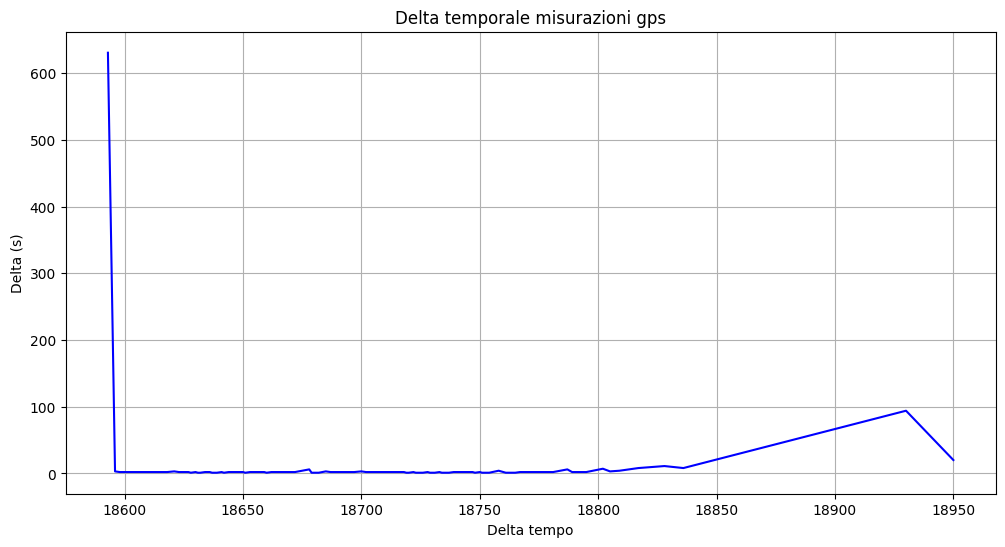

count    121.000000
mean       8.165289
std       57.741428
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max      631.000000
Name: delta_tempo, dtype: float64

In [29]:
## Delta tempo


plt.figure(figsize=(12, 6))
plt.plot(gdf1['unixtime'] - time_start, 
    gdf1['delta_tempo'], 
    label='Intervallo di tempo tra misurazioni', 
    color='blue'
    )

plt.xlabel('Delta tempo')
plt.ylabel('Delta (s)')
plt.title('Delta temporale misurazioni gps')
plt.grid(True)
#plt.ylim(0, 600)  ## max 600 secondi-> 10 minuti di pausa
#plt.xlim(12000, 16500)

plt.show()

gdf1["delta_tempo"].describe()


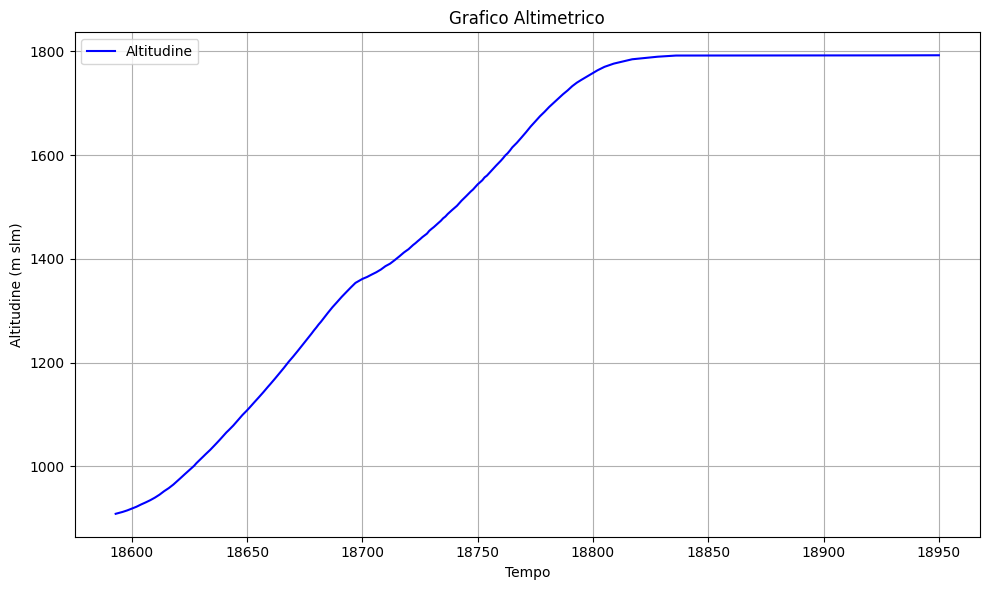

In [30]:
## Altimetria della giornata

plt.figure(figsize=(10, 6)) ##

plt.plot(gdf1['unixtime'] - time_start, 
    gdf1['altitudine'], 
    label='Altitudine', 
    color='blue')

plt.xlabel('Tempo')
plt.ylabel('Altitudine (m slm)')
plt.title('Grafico Altimetrico')
plt.grid(True)
plt.legend()

# Mostrare il grafico
plt.tight_layout()
plt.show()


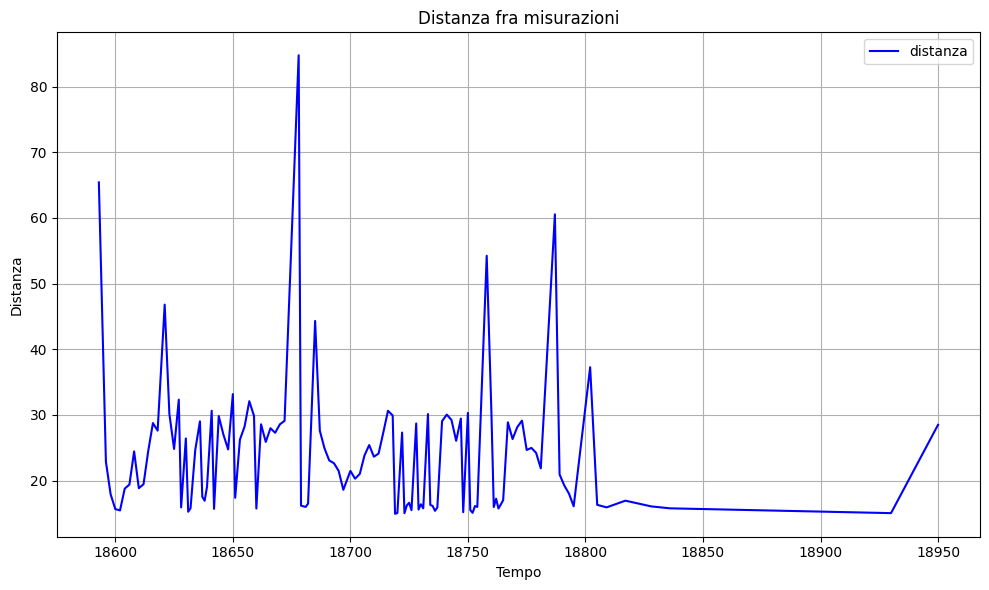

In [31]:
## Velocità della giornata

plt.figure(figsize=(10, 6)) ##

plt.plot(gdf1['unixtime'] - time_start, 
    gdf1['distanza_reale'], 
    label='distanza', 
    color='blue')

plt.xlabel('Tempo')
plt.ylabel('Distanza')
plt.title('Distanza fra misurazioni')
plt.grid(True)
plt.legend()
#plt.ylim(0,200)
#plt.xlim(24300, 24600)  ## max 600 secondi-> 10 minuti di pausa

# Mostrare il grafico
plt.tight_layout()
plt.show()

In [32]:
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
import branca.colormap as cm

# Assumo che il tuo GeoDataFrame sia già caricato in gdf1
# Centra la mappa sulla media delle coordinate
mappa = folium.Map(
    location=[gdf1['latitudine'].mean(), gdf1['longitudine'].mean()],
    zoom_start=12
)

# Crea una scala di colori per la velocità
colormap = cm.LinearColormap(
    colors=['blue', 'green', 'yellow', 'red'],
    vmin=gdf1['velocita'].min(),
    vmax=gdf1['velocita'].max()
)

# Aggiungi punti alla mappa
for _, row in gdf1.iterrows():
    folium.CircleMarker(
        location=[row['latitudine'], row['longitudine']],
        radius=5,
        color=colormap(row['velocita']),
        fill=True,
        fill_color=colormap(row['velocita']),
        fill_opacity=0.7,
        popup=f"Velocità: {row['unixtime']} m/s",
    ).add_to(mappa)

# Aggiungi una linea tra i punti per visualizzare il percorso
folium.PolyLine(
    locations=gdf1[['latitudine', 'longitudine']].values.tolist(),
    color="blue",
    weight=2.5,
    opacity=0.7
).add_to(mappa)

# Aggiungi la scala colori alla mappa
colormap.caption = "Velocità (m/s)"
mappa.add_child(colormap)

# Salva la mappa e visualizzala
##mappa.save("mappa.html")
mappa
